In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [240]:
titanic_data = pd.read_csv('train.csv')
titanic_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


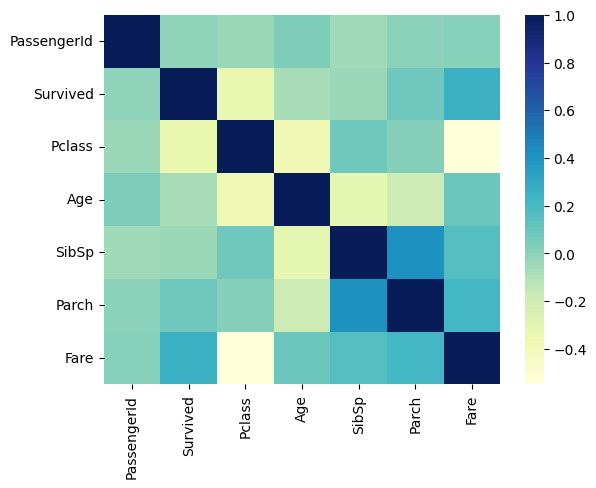

In [241]:
import seaborn as sns

# select only numerical values
numeric_data = titanic_data.select_dtypes(include=[np.number])

sns.heatmap(numeric_data.corr(), cmap='YlGnBu')
plt.show()

In [242]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(titanic_data, titanic_data[['Survived', 'Pclass', 'Sex']]):
    start_train_set = titanic_data.loc[train_indices]
    start_test_set = titanic_data.loc[test_indices]

<Axes: >

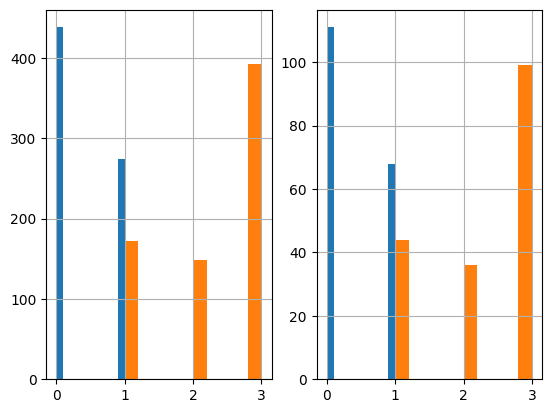

In [243]:
plt.subplot(1, 2, 1) 
start_train_set['Survived'].hist()
start_train_set['Pclass'].hist()

plt.subplot(1, 2, 2) 
start_test_set['Survived'].hist()
start_test_set['Pclass'].hist()

In [244]:
start_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 23 to 394
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          567 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        167 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [245]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):

    def fit(self, X, Y=None):
        return self
    
    def transform(self, X):
        imputer = SimpleImputer(strategy='mean')
        X['Age'] = imputer.fit_transform(X[['Age']])
        
        return X

In [246]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):

    def fit(self, X, Y=None):
        return self
    
    def transform(self, X):
        encode = OneHotEncoder()

        # Embarked column
        matrix = encode.fit_transform(X[['Embarked']]).toarray()
        column_names = ['C', 'S', 'Q', 'N']
        for i in  range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        # Sex column
        matrix = encode.fit_transform(X[['Sex']]).toarray()
        column_names = ['Female', 'Male']
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        return X

In [247]:
class FeatureDropper(BaseEstimator, TransformerMixin):

    def fit(self, X, Y=None):
        return self

    def transform(self, X):
        return X.drop(['Embarked', 'Sex', 'Name', 'Ticket', 'Cabin', 'N'], axis=1, errors='ignore')

In [248]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('ageimputer', AgeImputer()),
    ('featureencoder', FeatureEncoder()),
    ('featuredropper', FeatureDropper())
])

In [249]:
start_train_set = pipeline.fit_transform(start_train_set)

In [250]:
start_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
23,24,1,1,28.000000,0,0,35.5000,0.0,0.0,1.0,0.0,1.0
457,458,1,1,29.678131,1,0,51.8625,0.0,0.0,1.0,1.0,0.0
656,657,0,3,29.678131,0,0,7.8958,0.0,0.0,1.0,0.0,1.0
490,491,0,3,29.678131,1,0,19.9667,0.0,0.0,1.0,0.0,1.0
525,526,0,3,40.500000,0,0,7.7500,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
284,285,0,1,29.678131,0,0,26.0000,0.0,0.0,1.0,0.0,1.0
454,455,0,3,29.678131,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
381,382,1,3,1.000000,0,2,15.7417,1.0,0.0,0.0,1.0,0.0
700,701,1,1,18.000000,1,0,227.5250,1.0,0.0,0.0,1.0,0.0


In [251]:
start_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 23 to 394
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [252]:
from sklearn.preprocessing import StandardScaler

X = start_train_set.drop(['Survived'], axis=1)
Y = start_train_set['Survived']

X_data = StandardScaler().fit_transform(X)
Y_data = Y.to_numpy()
X_data[0]


array([-1.64493902, -1.56828591, -0.1340489 , -0.47518746, -0.4799619 ,
        0.06837964, -0.48149134, -0.31426968,  0.625     , -0.73561236,
        0.73561236])

In [253]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clk = RandomForestClassifier()

param_grid = [
    {'n_estimators': [10, 100, 200, 500, 1000]},
    {'max_depth': [None, 5, 10, 20]},
    {'min_samples_split': [2, 3, 4, 6]}
]

grid_search = GridSearchCV(
    clk,
    param_grid=param_grid,
    scoring='accuracy',
    return_train_score=True
)

grid_search.fit(X_data, Y_data)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid=[{'n_estimators': [10, 100, 200, 500, 1000]},
                         {'max_depth': [None, 5, 10, 20]},
                         {'min_samples_split': [2, 3, 4, 6]}],
             return_train_score=True, scoring='accuracy')

In [254]:
final_clf = grid_search.best_estimator_
final_clf

RandomForestClassifier(n_estimators=1000)

In [255]:
start_test_set = pipeline.fit_transform(start_test_set)

In [256]:
start_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 608 to 35
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  179 non-null    int64  
 1   Survived     179 non-null    int64  
 2   Pclass       179 non-null    int64  
 3   Age          179 non-null    float64
 4   SibSp        179 non-null    int64  
 5   Parch        179 non-null    int64  
 6   Fare         179 non-null    float64
 7   C            179 non-null    float64
 8   S            179 non-null    float64
 9   Q            179 non-null    float64
 10  Female       179 non-null    float64
 11  Male         179 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 18.2 KB


In [257]:
X_test = start_test_set.drop(['Survived'], axis=1)
Y_test = start_test_set['Survived']

X_data_test = StandardScaler().fit_transform(X_test)
Y_data_test = Y_test.to_numpy()

In [258]:
final_clf.score(X_data_test, Y_data_test)

0.8435754189944135

In [259]:
final_data = pipeline.fit_transform(titanic_data)
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [261]:
X_final = final_data.drop(['Survived'], axis=1)
Y_final = final_data['Survived']

X_data_final = StandardScaler().fit_transform(X_final)
Y_data_final = Y_final.to_numpy()

In [262]:
prod_clk = RandomForestClassifier()

param_grid = [
    {'n_estimators': [10, 100, 200, 500, 1000]},
    {'max_depth': [None, 5, 10, 20]},
    {'min_samples_split': [2, 3, 4, 6]}
]

grid_search = GridSearchCV(
    prod_clk,
    param_grid=param_grid,
    scoring='accuracy',
    return_train_score=True
)

grid_search.fit(X_data_final, Y_data_final)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid=[{'n_estimators': [10, 100, 200, 500, 1000]},
                         {'max_depth': [None, 5, 10, 20]},
                         {'min_samples_split': [2, 3, 4, 6]}],
             return_train_score=True, scoring='accuracy')

In [263]:
final_prod_clf = grid_search.best_estimator_
final_prod_clf

RandomForestClassifier(max_depth=5)

In [264]:
titanic_test_data = pd.read_csv('test.csv')
titanic_test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [265]:
titanic_test_data = pipeline.fit_transform(titanic_test_data)

In [267]:
titanic_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   S            418 non-null    float64
 8   Q            418 non-null    float64
 9   Female       418 non-null    float64
 10  Male         418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.0 KB


In [268]:
X_final_test = titanic_test_data
X_final_test = X_final_test.fillna(method='ffill')

X_data_final_test = StandardScaler().fit_transform(X_final_test)

C:\Users\meetp\AppData\Local\Temp\ipykernel_10824\4129418513.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method='ffill')


In [269]:
predictions = final_prod_clf.predict(X_data_final_test)

In [271]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv('predictions.csv', index=False)

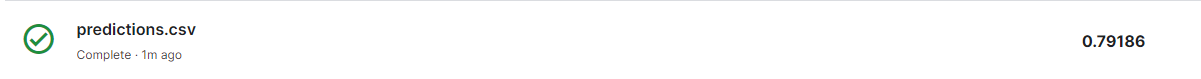